# Part 1: Car Insurance Claims

What is the target? (You are required to complete a classification task for this project)
OUTCOME, i.e. has the person filed a claim or not

What does one row represent? (A person? A business? An event? A product?)
One person (first column is Unique ID)

How many features does the data have?
19, including target

How many rows are in the dataset?
10,000

What opportunities exist for dimensionality reduction or feature selection with this dataset?

What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

Explore/clean the data

Create exploratory visualizations to understand your data and search for trends.

Choose a model

Preprocess data

Fit and evaluate a default model

Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4)

Add your observations in a Markdown: Do these features make sense based on the business case?

Create Explanatory Visualizations for the most important features.

- Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.
  
    - The purpose is to demonstrate key trends you found that will be of interest to a stakeholder.
      
        - These visuals should be reporting-quality with titles, labels, and a short explanation of the trend. Be sure to explain in a text cell the insight associated with each visual. Both of these visualizations should be easily understood by a non-technical audience (Neither of these should be histograms, boxplots, or correlation plots).

        - These will be added to your readme in part 4

## Explore and Clean the Data

### Import Packages

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn import set_config
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, metrics
set_config(transform_output='pandas')

### Declare Functions

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

def summarize_df(df_):
    df = df_.copy()
    report = pd.DataFrame({
                        'dtype':df.dtypes,
                        '# null': df.isna().sum(),
                        'null (%)': df.isna().sum()/len(df)*100,
                        'nunique':df.nunique(),
                        "min":df.min(),
                        'max':df.max()
             })
    report.index.name='Column'
    return report.reset_index()

In [3]:
def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [4]:
# load data
df = pd.read_csv('Data/Car_Insurance_Claim.csv')

# preview data
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1,after 2015,0,1,10238,12000.0,sedan,0,0,0,0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0,before 2015,0,0,10238,16000.0,sedan,0,0,0,1
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1,before 2015,0,0,10238,11000.0,sedan,0,0,0,0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1,before 2015,0,1,32765,11000.0,sedan,0,0,0,0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1,before 2015,0,0,32765,12000.0,sedan,2,0,1,1


In [5]:
# view number of rows and columns
df.shape

(10000, 19)

In [6]:
# check for duplicate values
df.duplicated().sum()

0

In [7]:
# check for missing values
df.isna().sum()

ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [8]:
# drop unnecessary columns
df = df.drop(columns=['ID'])

In [9]:
# rename columns


In [10]:
# verify change
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  int64  
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  int64  
 10  CHILDREN             10000 non-null  int64  
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICLE_TYPE         10000 non-null  object 
 14  SPEEDING_VIOLATIONS  10000 non-null  int64  
 15  DUIS                 10000 non-null  

In [11]:
# check categorical data for cardinality
df.select_dtypes('object').nunique()

AGE                   4
GENDER                2
RACE                  2
DRIVING_EXPERIENCE    4
EDUCATION             3
INCOME                4
VEHICLE_YEAR          2
VEHICLE_TYPE          2
dtype: int64

In [12]:
# check consistency of numerical data
df.describe()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


## Create exploratory visualizations to understand your data and search for trends

In [13]:
summarize_df(df)

,Column,dtype,# null,null (%),nunique,min,max
0,AGE,object,0,0.00,4,16-25,65+
1,GENDER,object,0,0.00,2,female,male
2,RACE,object,0,0.00,2,majority,minority
3,DRIVING_EXPERIENCE,object,0,0.00,4,0-9y,30y+
4,EDUCATION,object,0,0.00,3,high school,university
5,INCOME,object,0,0.00,4,middle class,working class
6,CREDIT_SCORE,float64,982,9.82,9018,0.053358,0.960819
7,VEHICLE_OWNERSHIP,int64,0,0.00,2,0,1
8,VEHICLE_YEAR,object,0,0.00,2,after 2015,before 2015
9,MARRIED,int64,0,0.00,2,0,1


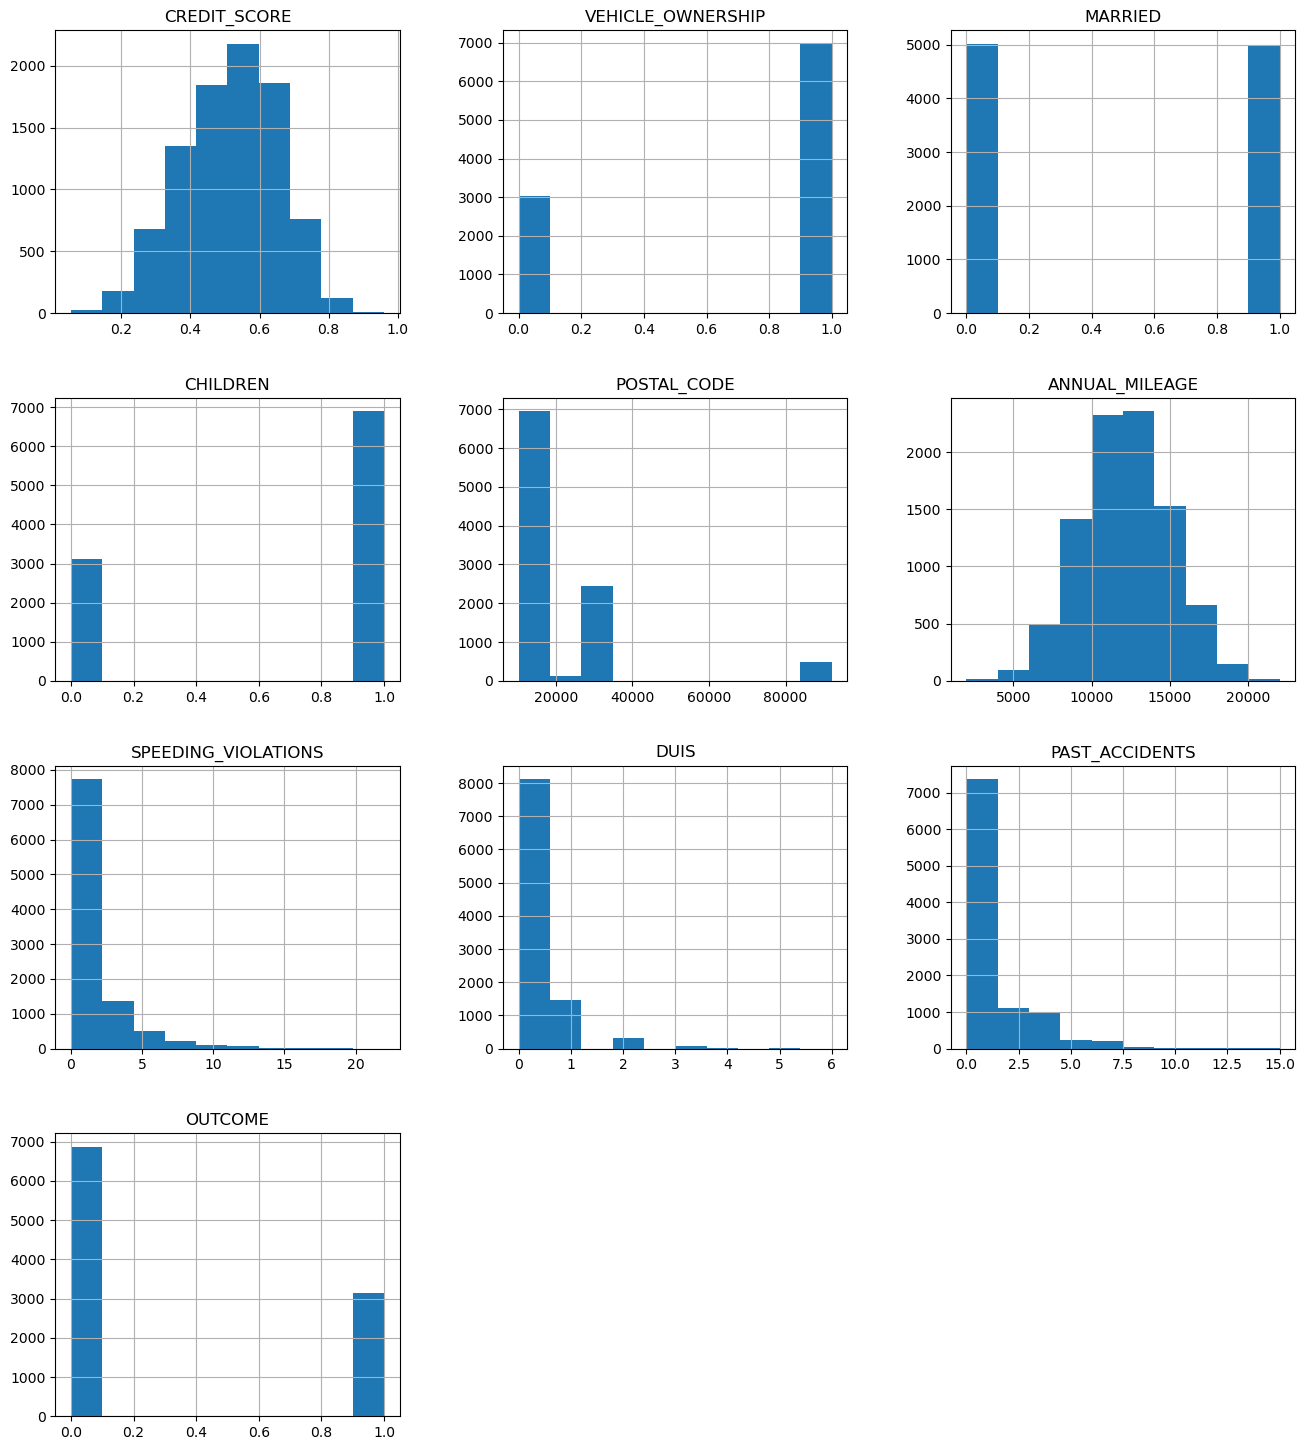

In [14]:
df.hist(figsize=(16,18));

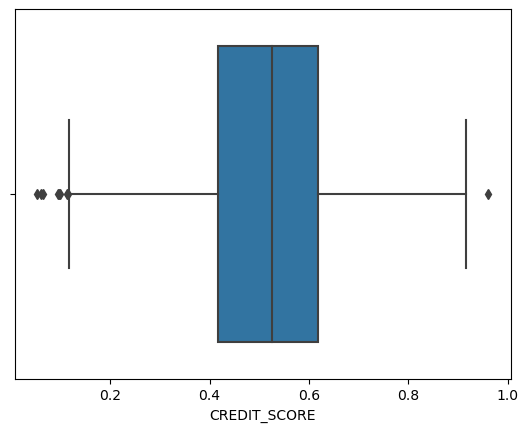

In [15]:
ax = sns.boxplot(data=df, x="CREDIT_SCORE")

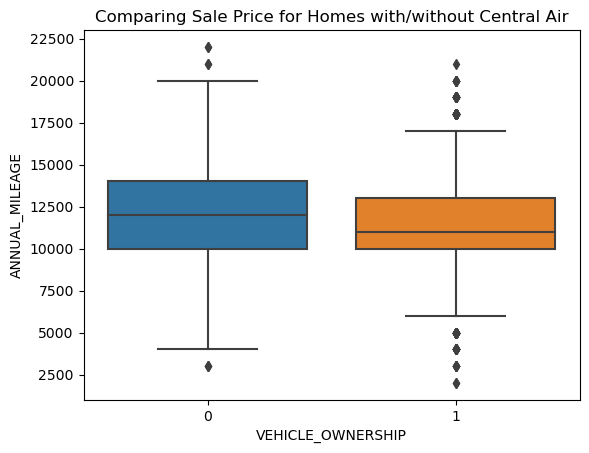

In [16]:
# Horizontal grouped boxplot in seaborn
ax = sns.boxplot(data=df, x='VEHICLE_OWNERSHIP', y="ANNUAL_MILEAGE")
ax.set_title("Comparing Sale Price for Homes with/without Central Air");

In [17]:
# Using select dtypes to get names of categorical columns
cat_cols = df.select_dtypes('object').columns
cat_cols

Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object')

AGE count plot 



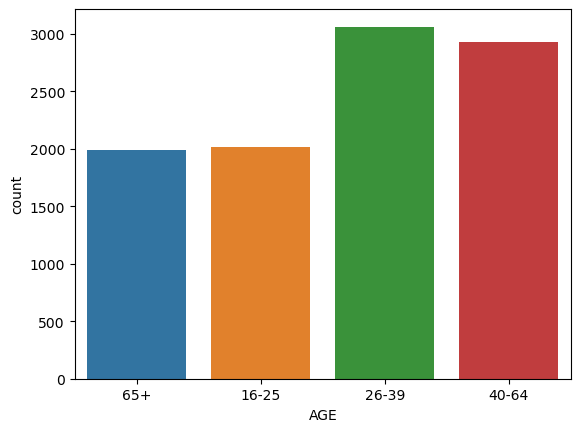

GENDER count plot 



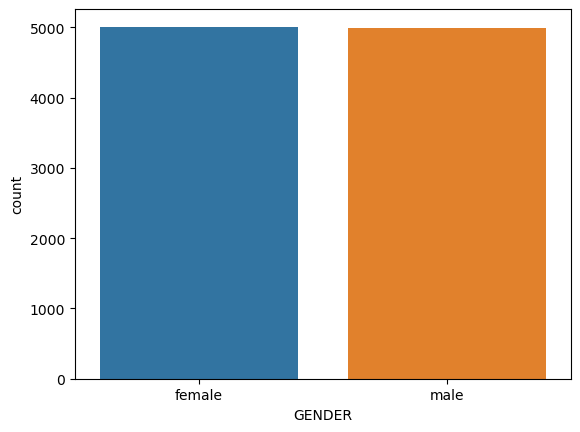

RACE count plot 



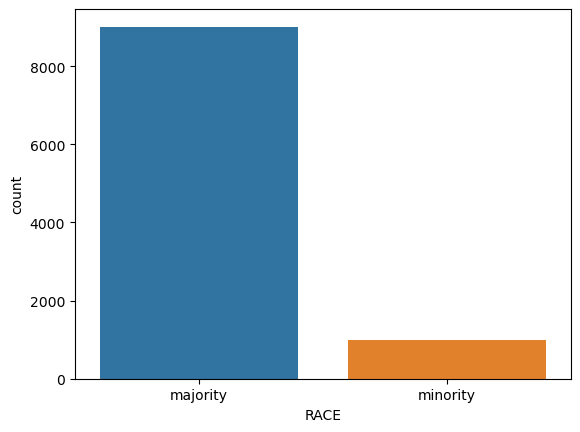

DRIVING_EXPERIENCE count plot 



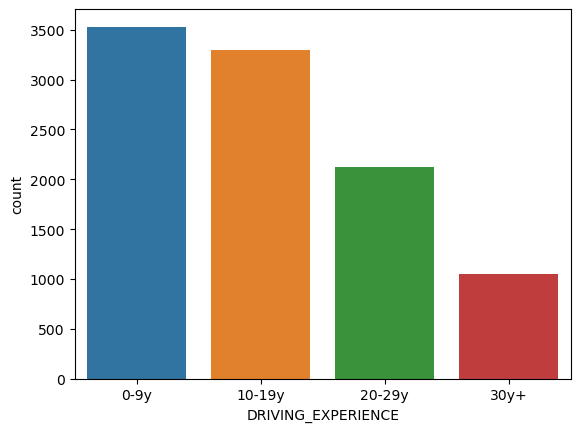

EDUCATION count plot 



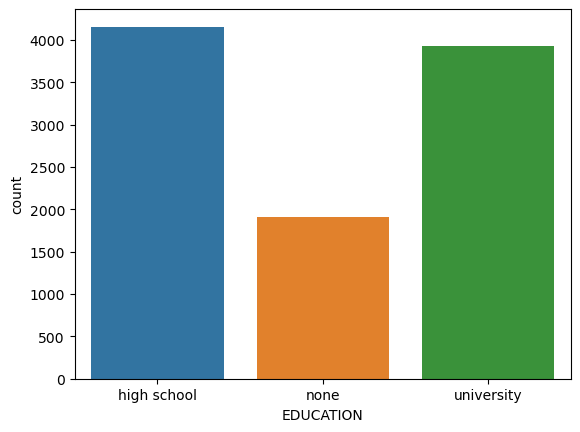

INCOME count plot 



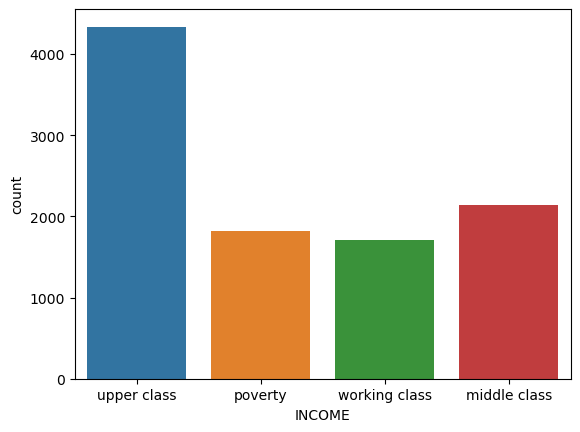

VEHICLE_YEAR count plot 



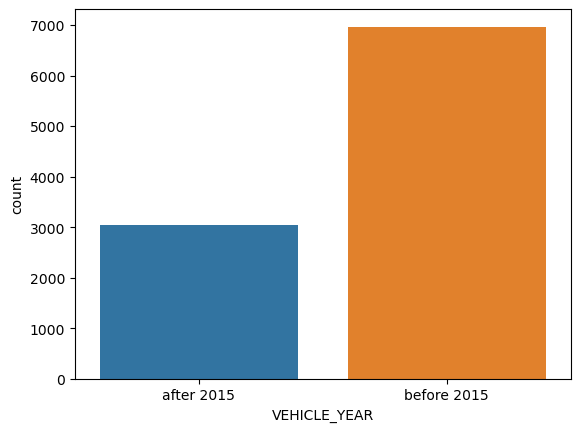

VEHICLE_TYPE count plot 



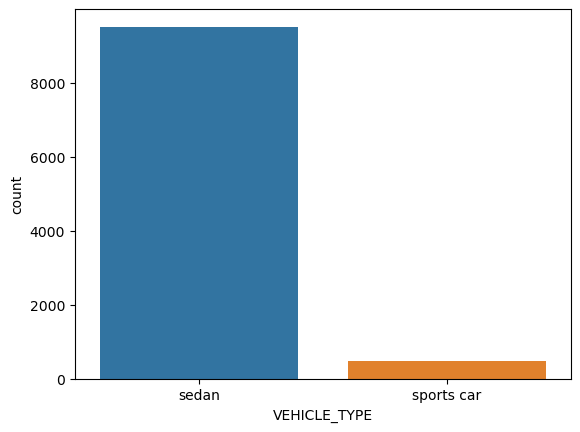

In [18]:
# for loop to print count plots for each categorical column
for col in cat_cols:
    print(col +' count plot \n') 
    sns.countplot(x =col, data =df)
    plt.show()

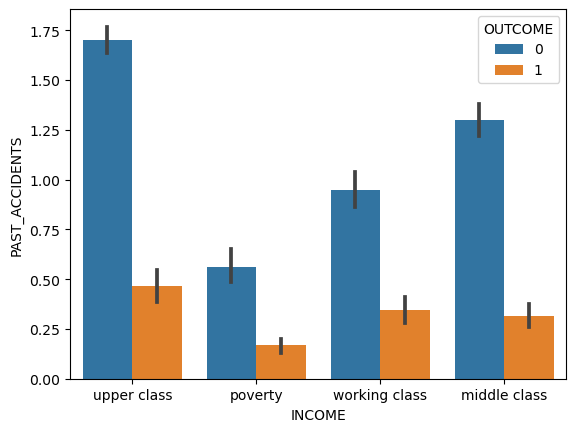

In [19]:
# Using seaborn to plot the group means by income colored by outcome 
ax = sns.barplot(data=df, x="INCOME", y="PAST_ACCIDENTS", hue='OUTCOME')

## Choose a model
knn

In [20]:
# define X and y
X = df.drop(columns=['OUTCOME'])
y = df['OUTCOME']

In [21]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Preprocess data

In [22]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

OneHotEncoder Columns: Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object')


In [23]:
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

Numeric Columns: Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')


## Fit and Evaluate a default model

In [24]:
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)

In [25]:
# Define KNN model pipeline
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
# Instantiate default KNN
knn = KNeighborsClassifier()
knn.fit(X_train_proc, y_train)

KNeighborsClassifier()

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      5144
           1       0.79      0.77      0.78      2356

    accuracy                           0.87      7500
   macro avg       0.85      0.84      0.84      7500
weighted avg       0.86      0.87      0.86      7500



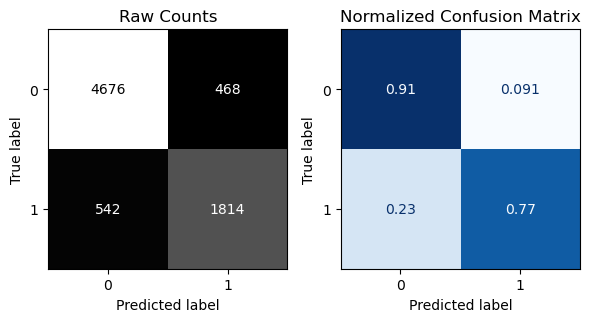


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1723
           1       0.71      0.69      0.70       777

    accuracy                           0.82      2500
   macro avg       0.79      0.78      0.78      2500
weighted avg       0.82      0.82      0.82      2500



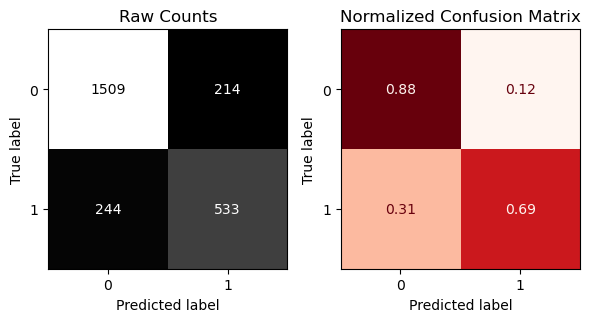

In [27]:
# evaluate
evaluate_classification(knn, X_train_proc, y_train, X_test_proc, y_test)

## Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4)

In [28]:
# import package
from sklearn.inspection import permutation_importance

In [29]:
## Calculate feature importances
importances = permutation_importance(knn, X_test_proc, y_test)

## Create a Series of Feature Importances
importances_df = pd.Series(importances['importances_mean'], index=knn.feature_names_in_)

In [30]:
importances_df.sort_values(ascending=False).head(10)

VEHICLE_OWNERSHIP            0.04744
DRIVING_EXPERIENCE_0-9y      0.01352
MARRIED                      0.01168
DRIVING_EXPERIENCE_10-19y    0.01136
PAST_ACCIDENTS               0.01024
ANNUAL_MILEAGE               0.00984
POSTAL_CODE                  0.00912
VEHICLE_YEAR_before 2015     0.00880
VEHICLE_YEAR_after 2015      0.00880
GENDER_female                0.00840
dtype: float64

## Add your observations in a Markdown: Do these features make sense based on the business case?

Most of them do, such as vehicle ownership (presumably, a car owner is more likely to file a claim than a non-car owner), followed by the smallest range of the Driving Experience which also makes sense (i.e. less experienced drivers are more likely to make mistakes resulting in an accident or infraction and therefore more likely to require submitting a claim). Other features such as married or vehicle year would require further investigation. 

## Create Explanatory Visualizations for the most important features.

- Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.
  
    - The purpose is to demonstrate key trends you found that will be of interest to a stakeholder.
      
        - These visuals should be reporting-quality with titles, labels, and a short explanation of the trend. Be sure to explain in a text cell the insight associated with each visual. Both of these visualizations should be easily understood by a non-technical audience (Neither of these should be histograms, boxplots, or correlation plots).

        - These will be added to your readme in part 4

The visualization below shows insight into the relationship between driving experience and filing an insurance claim ('OUTCOME'). By looking at the first range of driving experience (0-9), it's apparent that the highest number of drivers (about 2,200) filing claims this year had less than 10 years of driving experience.

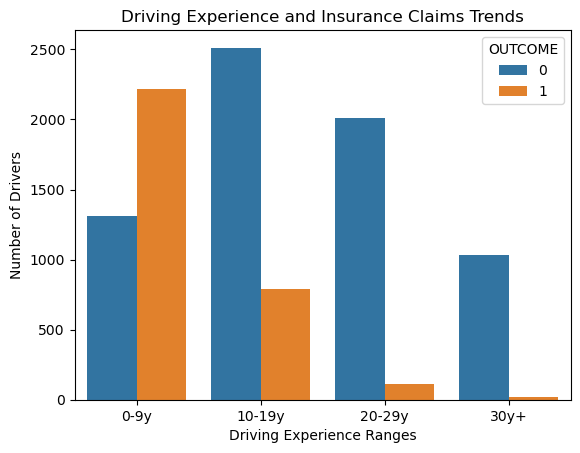

In [31]:
ax =sns.countplot(data=df,x='DRIVING_EXPERIENCE',hue = 'OUTCOME').set(
    title='Driving Experience and Insurance Claims Trends',
    xlabel='Driving Experience Ranges',
    ylabel = 'Number of Drivers');

The visualization below shows insight into the relationship between a driver's marriage (0 = not married, 1 = married) status and filing an insurance claim (0 = not filed, 1 = filed). We can see here that the number of claims filed by unmarried drivers (about 2,000) is about twice as many as those filed by married drivers.

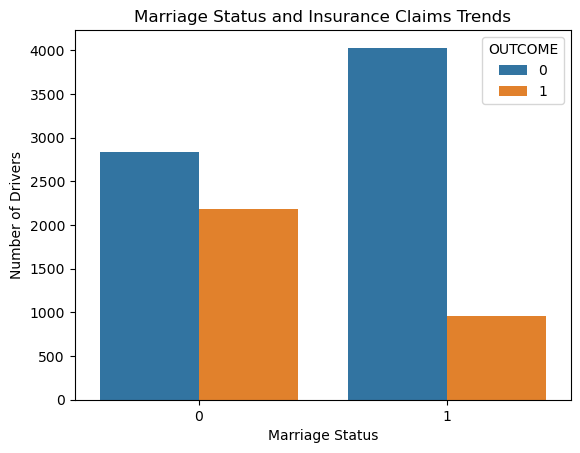

In [32]:
sns.countplot(data=df, x="MARRIED", hue="OUTCOME").set(
    title="Marriage Status and Insurance Claims Trends",
    xlabel="Marriage Status",
    ylabel="Number of Drivers",
);

## Part 2: Feature Selection/Engineering

​Task:

Choose at least one feature selection or feature engineering method to apply to the data and compare the models’  performance with and without feature selection/engineering.

Some options include:

Apply PCA  to keep .85 variance ratio 

Apply PCA to get 3 principal components for the data. Concatenate/combine these PC’s with the original features (X_train, X_test data).

Apply Clustering, select the appropriate number of clusters, and use the clustering object to get predicted clusters for the training and test data. Concatenate/combine these clusters with the original features. 

Create additional features by applying the feature engineering techniques demoed on the LP.

Fit and evaluate a model using your updated/expanded features and compare it to your model from Part 1.

Apply at least one method of feature selection (filtering, embedded, wrapper).

Fit and evaluate a final model using the selected features.

Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4). 

In a Markdown cell, comment on how these features compare to the model from Part 1. Are there any new features in the top 10?

### Apply PCA to keep .85 variance ratio

In [33]:
# instantiate PCA with .85 as argument for 85%
pca = PCA(n_components=.85)

In [34]:
# make pipeline with pca
pca_pre = make_pipeline(preprocessor, pca)

In [35]:
# fit and transform
X_train_pca = pca_pre.fit_transform(X_train)
X_test_pca = pca_pre.transform(X_test)

### run KNN again with pca pipeline

In [36]:
# instantiate model
knn_pca = KNeighborsClassifier()

In [37]:
# fit on new pca data
knn_pca.fit(X_train_pca, y_train)

KNeighborsClassifier()

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      5144
           1       0.80      0.77      0.79      2356

    accuracy                           0.87      7500
   macro avg       0.85      0.84      0.85      7500
weighted avg       0.87      0.87      0.87      7500



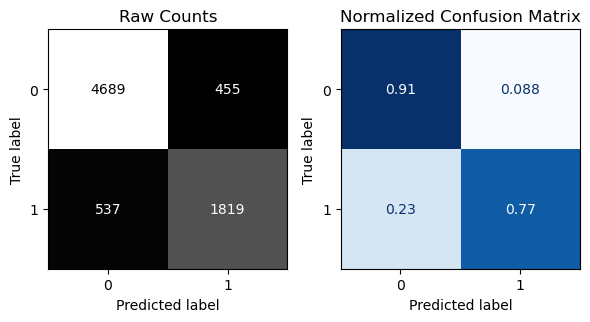


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1723
           1       0.70      0.68      0.69       777

    accuracy                           0.81      2500
   macro avg       0.78      0.77      0.78      2500
weighted avg       0.81      0.81      0.81      2500



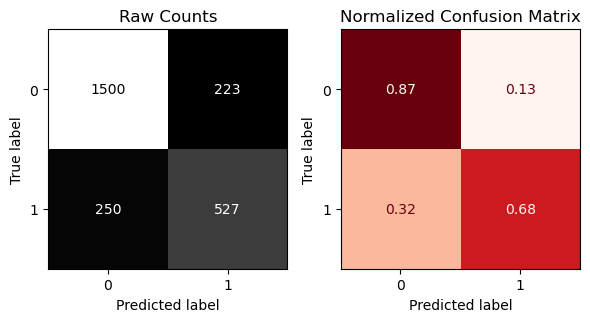

In [38]:
# run evaluation function
evaluate_classification(knn_pca, X_train_pca, y_train, 
                 X_test_pca, y_test)

### Compared to Model from Part 1

The accuracy was reduced slightly from using the original KNN (from 0.82 to 0.81) to using with PCA, while precision, recall, and f1-score slightly increased.

## Feature Selection: Filtering - Correlation

In [39]:
# check target for class balance
y.value_counts(1)

0    0.6867
1    0.3133
Name: OUTCOME, dtype: float64

In [40]:
# address imbalance with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_sm,y_train_sm = smote.fit_resample(X_train_proc, y_train)
y_train_sm.value_counts()

1    5144
0    5144
Name: OUTCOME, dtype: int64

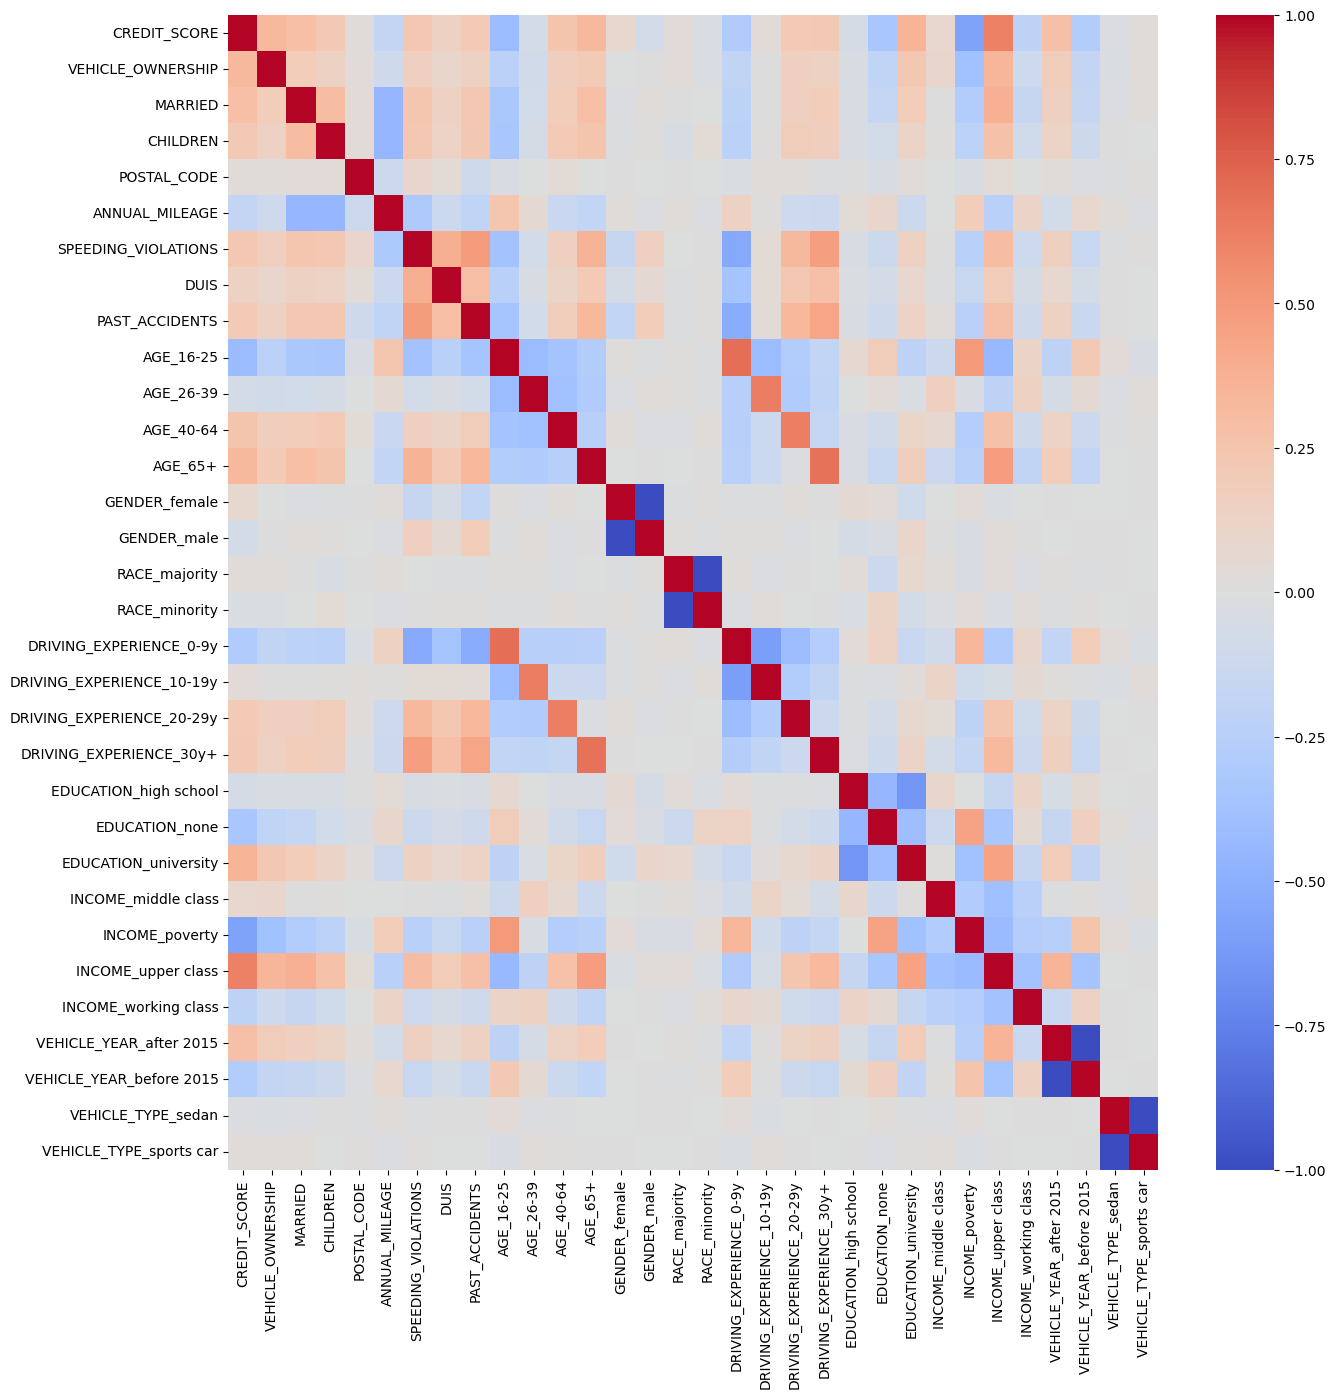

In [41]:
# Make a correlation heatmap of all features
corr = X_train_sm.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

In [42]:
# import required packages to address collinearity
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif

In [43]:
# Instantiate the selector, indicate theshold for r, also include the appropriate scoring metric for the task
selector = SelectNonCollinear(correlation_threshold = 0.75, scoring = f_classif)

In [44]:
# Fit on the training data, use .values
selector.fit(X_train_sm.values, y_train_sm.values)

In [45]:
# Define a mask for filtering
non_collinear = selector.get_support()
non_collinear[:5]

[True, True, True, True, True]

In [46]:
# Check how many features are below the theshold
non_collinear.count(True)

28

In [47]:
# Check how many features are above the theshold
non_collinear.count(False)

4

In [48]:
# Filter training data
training_data_to_keep = X_train_sm.values[:, non_collinear]
# Filter column names
columns = np.array(X_train_sm.columns)[non_collinear]
# Make traing data into a dataframe
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

# Filter testing data
test_data_to_keep = X_test_proc.values[:, non_collinear]
# Make test data into a dataframe
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)

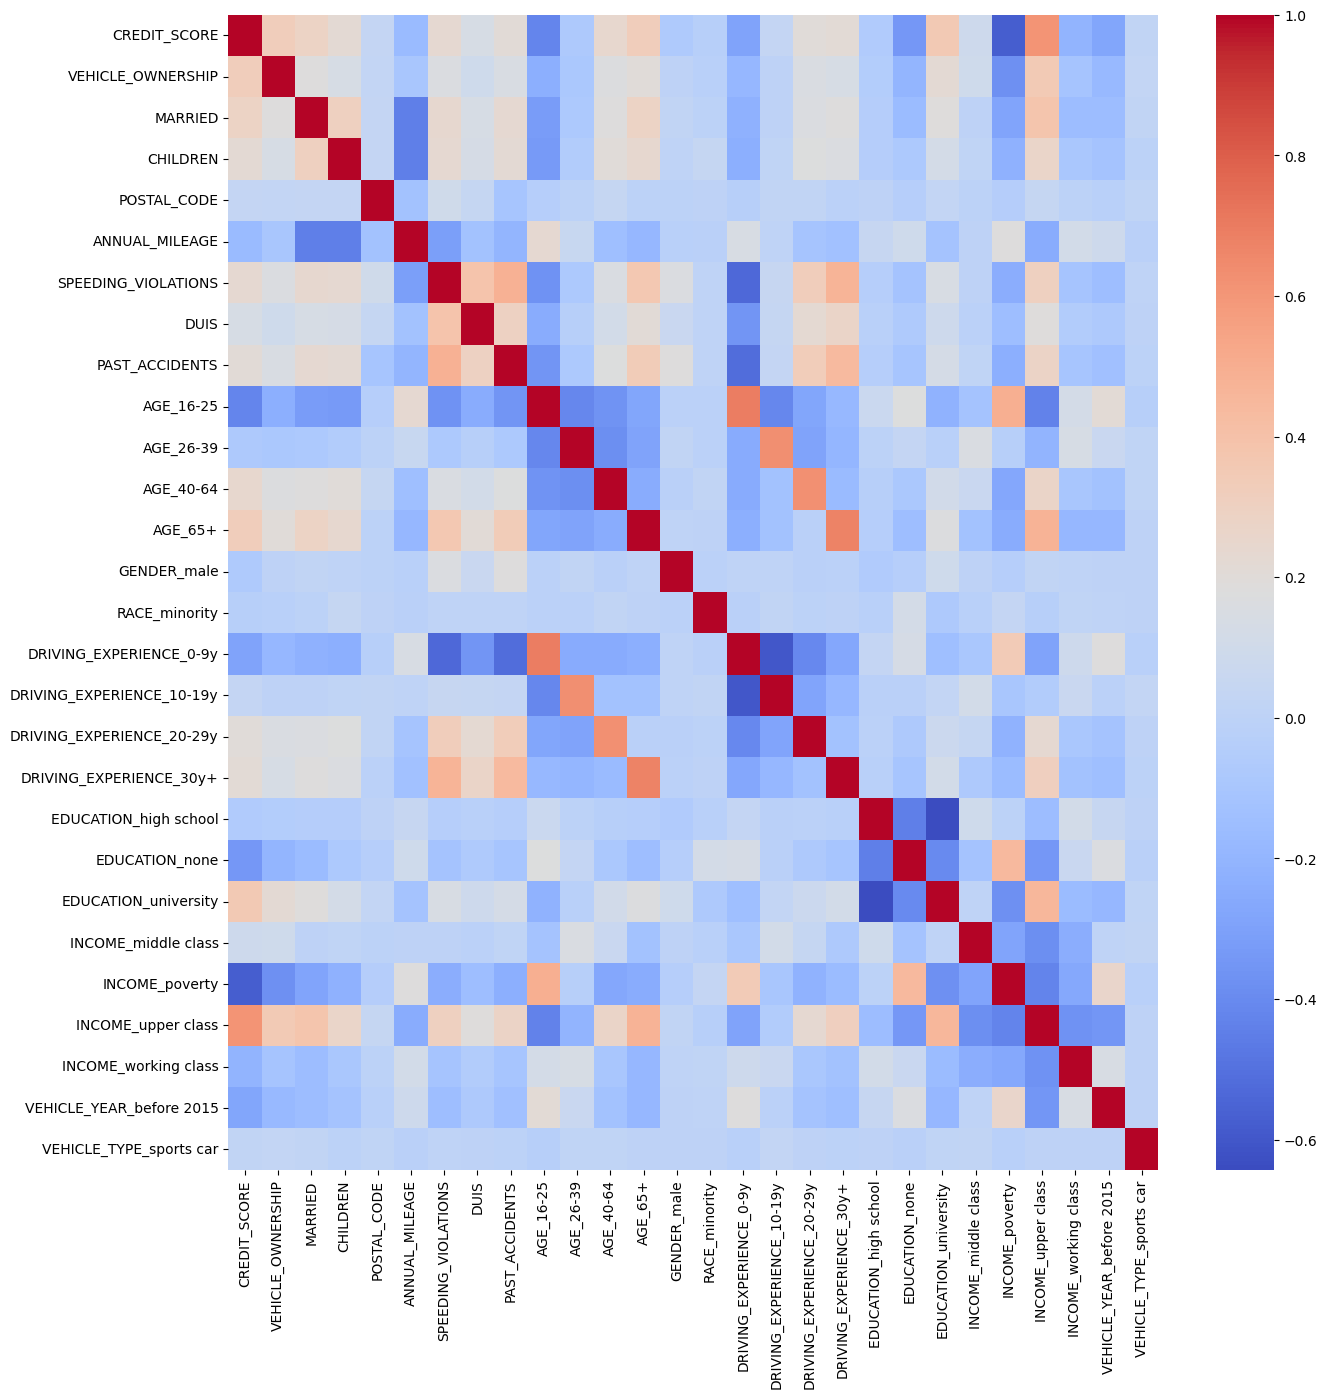

In [49]:
# Make correlation heatmap for non_collinear features
corr = X_train_no_corr.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

In [50]:
# Instantiate default KNN
knn_no_corr = KNeighborsClassifier()

In [51]:
# fit KNN
knn_no_corr.fit(X_train_no_corr, y_train_sm)

KNeighborsClassifier()

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      5144
           1       0.84      0.96      0.90      5144

    accuracy                           0.89     10288
   macro avg       0.90      0.89      0.89     10288
weighted avg       0.90      0.89      0.89     10288



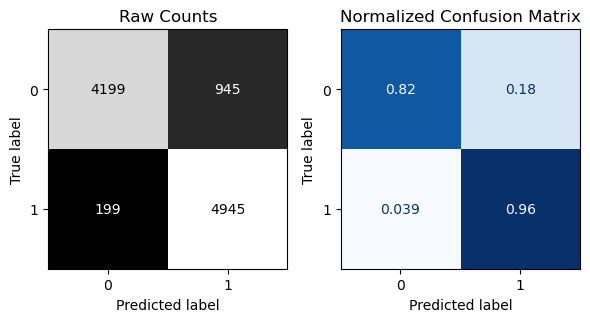


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1723
           1       0.60      0.81      0.69       777

    accuracy                           0.77      2500
   macro avg       0.75      0.78      0.75      2500
weighted avg       0.80      0.77      0.78      2500



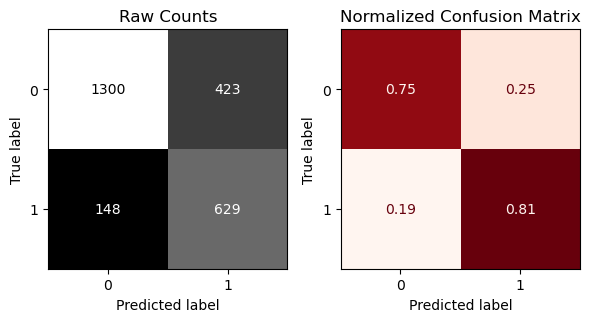

In [52]:
evaluate_classification(knn_no_corr, X_train_no_corr, y_train_sm, X_test_no_corr, y_test)

## Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4)

In [53]:
## Calculate feature importances
importances_2 = permutation_importance(knn_no_corr, X_test_no_corr, y_test)

In [54]:
## Create a Series of Feature Importances
importances_2_df = pd.Series(importances_2['importances_mean'],index=knn_no_corr.feature_names_in_)

In [55]:
importances_2_df.sort_values(ascending=False).head(10)

VEHICLE_OWNERSHIP            0.04320
DRIVING_EXPERIENCE_10-19y    0.01584
VEHICLE_YEAR_before 2015     0.01336
SPEEDING_VIOLATIONS          0.01328
DRIVING_EXPERIENCE_0-9y      0.01224
POSTAL_CODE                  0.01208
DRIVING_EXPERIENCE_20-29y    0.01136
GENDER_male                  0.01032
MARRIED                      0.01024
AGE_26-39                    0.00624
dtype: float64

#### In a Markdown cell, comment on how these features compare to the model from Part 1. Are there any new features in the top 10?

Vehice ownership is still the top important feature, although it saw a bit of a decrease (.05225 to .04016). Marriage status dropped from 6th to 9th, and DUIs made a new appearance in 10th place. Annual Mileage was a feature that was high, at 2nd, and now no longer shows up. Driving experience ranges 10-19 and 0-9 remained, and 20-29 newly appeared as well. Speeding Violations are also a new feature that shows up. Interestingly, female gender no longer appears, previously #10, but the male gender feature shoots up to 4th in ranking, previously at 9th.

## Part 3: Build a small neural network

In [56]:
# imports for modeling
from sklearn.metrics import mean_absolute_error, r2_score, \
mean_squared_error, precision_score, recall_score, accuracy_score, f1_score, \
ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError
tf.keras.optimizers.legacy.Adam()

rmse = RootMeanSquaredError()

# This is used to overcome an issue with setting up tensorflow in M1/M1
# Suspect tensorflow-macos not very fit with GPU, use CPU only with
tf.config.set_visible_devices([], 'GPU')

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Task: ​Build a small neural network (with only 1 hidden layer)

### Ensure the final layer is appropriate for your task (number of units and activation function).

In [65]:
# define input shape
input_shape = X_train_proc.shape[1]
# Build binary classification model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(10, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(10, 
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [66]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                330       
                                                                 
 dense_9 (Dense)             (None, 10)                110       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


### Fit it for 50 epochs

### Use the Early Stopping callback

### Start with patience =5 monitoring val_accuracy.

### Use a validation_split of .2

### Save the history and visualize it.

### Evaluate the model using sklearn evaluation metrics:

Confusion Matrix 

Classification Report

You are welcome to use the custom evaluation functions





In [ ]:
# evaluate the model with sklearn metrics
test_preds = model.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');

### Tune at least 3 parameters with the Keras tuner:

Include a dropout layer and adjust the dropout rate.

Number of Units

Optimizer

Learning rates

### Evaluate your best model on unseen test data